Name: Kagen Lim

Completed as Assignment #2: Write up a report that makes use of Covid Positive X-Ray image data.

Contact: [kagen.lim@columbia.edu](mailto:kagen.lim@columbia.edu)

GitHub Repo: https://github.com/kagenlim/Advanced-Machine-Learning

In this notebook, I use deep learning methods to predict COVID positivity, based on x-ray images. Specifically, in the model experimentation process, I apply neural networks with convolutional layers, and also fit transfer learning models in order to predict COVID positivity well.

This notebook utitlizes image data from a paper published first as a pre-print on arXiv, then later in *IEEE Access*:
```
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145 (Links to an external site.)

M. E. H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, "Can AI Help in Screening Viral and COVID-19 Pneumonia?," in IEEE Access, vol. 8, pp. 132665-132676, 2020, doi: 10.1109/ACCESS.2020.3010287. 
```

# Loading Data in and Early Preprocessing

In [ ]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

In [2]:
import sys
import time
import cv2 #computervision library
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize #imagetransformer
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [ ]:
# Download and unzip data from a Google Drive Folder
#This is command line code which works fine in Google Colab, but not locally on Jupyter/on an IDE#
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
!unzip COVID-19_Radiography_Database.zip

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia'] #List of File Names

# load file names to fnames list object
fnames = []
for category in categories: #looping through the categories, and scanning for each and every file#
    covid_folder = os.path.join(base_path, category) #full directory location
    file_names = os.listdir(covid_folder) #list of file names#
    full_path = [os.path.join(covid_folder, file_name) for file_name in file_names] #creating the full path with this for loop
    fnames.append(full_path) 

print('Number of categories:', len(fnames) ) #list of lists
print('Number of images for each category:', [len(f) for f in fnames]) #object that has a bunch of file names#
print(fnames[0:4]) #examples of file names

In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, shape)
        img = img / np.amax(img) #ensures that each img value is between zero and one, effectively min max transform


        # Resize the images.
        X = np.array(img)

        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single COVID file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

(192, 192, 3)

In [6]:
# Create list of file paths
covid_filepaths=fnames[0]+fnames[1]+fnames[2] #list in file directories; large list of file paths#

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,covid_filepaths )) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [7]:
X.shape

(3886, 192, 192, 3)

In [8]:
print(len(preprocessed_image_data) ) #same number of elements as filenames #number of images
print(preprocessed_image_data[2002].shape ) #dimensions now 192,192,3 for all images #dimensions of each image tensor
print(preprocessed_image_data[2002].min() ) #min value of image is zero
print(preprocessed_image_data[2002].max() ) #min value of image is zero

3886
(192, 192, 3)
0.0
1.0


In [165]:
from itertools import repeat

print('Number of images for each category:', [len(f) for f in fnames])
categories = ['COVID', 'NORMAL', 'PNEUMONIA'] #List of File Names
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
viral_pneu=list(repeat("PNEUMONIA", 1345))

#concat into single list of y labels
y_labels = covid+normal+viral_pneu 

#check length, same as X above
len(y_labels) 

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels) #one-hot encode#

display(y) #for three categories, three variables out of this. 

Number of images for each category: [1200, 1341, 1345]


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)
#stratified because of multi-class classification

In [83]:
y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

In [84]:
y_train.head() 

,COVID,NORMAL,PNEUMONIA
3256,0,0,1
1265,0,1,0
1188,1,0,0
118,1,0,0
3215,0,0,1


In [85]:
y_test.head()

,COVID,NORMAL,PNEUMONIA
3235,0,0,1
2083,0,1,0
1041,1,0,0
1781,0,1,0
3070,0,0,1


# Dataset Description and Motivation for Machine Learning Modelling

There are three main categories in this dataset, containing three types of X-Ray images: Normal Lungs, Lungs of COVID-19 Positive Patients who have Pneumonia, and Lungs of Patients who have Viral Pneumonia (non-COVID-19 viral related causes, presumably).

There are potential, categorical differences between the three types of X-ray images, as visualized below here. The COVID-19 Pneumonia patients' X-rays have what researchers have called 'ground-glass opacity' in the following paper:

```
Smith, D. L., Grenier, J.-P., Batte, C., & Spieler, B. (2020). A Characteristic Chest Radiographic Pattern in the Setting of the COVID-19 Pandemic. Radiology: Cardiothoracic Imaging, 2(5), e200280. https://doi.org/10.1148/ryct.2020200280
```

In other words, there is a white, patchy quality to the X-Ray images of COVID-19 patients. The X-Ray images of Viral Pneumonia patients seem to have less of this white, patchy quality, while the X-ray images healthy patients' lungs appear to be the clearest, with little to none of this white, patchy translucency.

## Healthy Patients

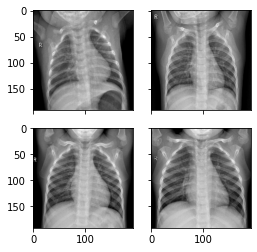

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1300).png')
im2 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (188).png')
im3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (405).png')
im4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (691).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

## COVID 19-Patients

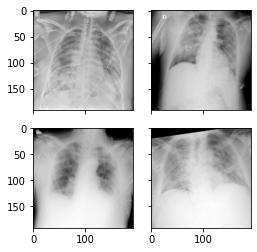

In [15]:
imc1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1065).png')
imc2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (312).png')
imc3 =preprocessor('COVID-19 Radiography Database/COVID/COVID (49).png')
imc4 =preprocessor('COVID-19 Radiography Database/COVID/COVID (774).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [imc1, imc2, imc3, imc4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

## Viral Pneumonia Patients

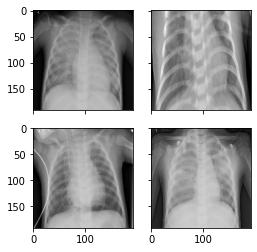

In [16]:
imp1 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1006).png')
imp2 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (227).png')
imp3 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (672).png')
imp4 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (38).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [imp1, imp2, imp3, imp4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

Supervised machine learning models are ideal for handling this kind of problem, also known as classification problems, in which the goal of the modelling process is to train given models to detect given categories. A well-trained classification model should be able to classify unseen data well, into given categories. 

A particularly useful type of supervised machine learning model for such X-ray image data, within the field of deep learning, are neural network models with convolutional layers. Among other qualities, such models are adept at parameter sharing due to the existence of the convolutional layers (also known as filters), which are especially good for detecting consistent patterns across a given image. 

Hence, neural networks with convolutional layers might be trained to be accurate in detecting whether a given case of pneumonia is viral or possibly caused by COVID-19, or if a patient is healthy with pneumonia. This is a non-invasive way of doing such medical assessments since only a X-ray images of a patient's lungs are required. This is a promising application of AI or Machine Learning models to medical assessments. This modelling goal will be pursued in this notebook.

#Three Prediction Models

## SqueezeNet with Batch Normalization

In [23]:
# Adding batch normalization to assist with optimization for deeper network

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

#batch normalization
  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y) #within Fire Modules#
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    return tf.keras.layers.concatenate([y1, y3]) #how to use the first modules

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same',  activation='relu')(x)
  y = tf.keras.layers.BatchNormalization()(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(72, 256)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(96, 512)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(3, activation='softmax')(y)

  #stacking layers one on top of another

  model = tf.keras.Model(x, y) #input object and output object, fed in, as separate projects

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping 
  mc = ModelCheckpoint('best_model_squeezenet.h5', monitor='acc',mode='max', verbose=1, save_best_only=True) 
  red_lr= ReduceLROnPlateau(monitor='acc',patience=2,verbose=1,factor=0.5, min_lr=0.001)
  es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=5)

model.fit(X_train, y_train,
          epochs = 100, verbose=1,callbacks=[es,mc,red_lr])

Train on 3108 samples
Epoch 1/100
3104/3108 [============================>.] - ETA: 0s - loss: 0.3285 - acc: 0.8805
Epoch 00001: acc improved from -inf to 0.88063, saving model to best_model_squeezenet.h5
3108/3108 [==============================] - 21s 7ms/sample - loss: 0.3282 - acc: 0.8806
Epoch 2/100
3104/3108 [============================>.] - ETA: 0s - loss: 0.1739 - acc: 0.9388
Epoch 00002: acc improved from 0.88063 to 0.93887, saving model to best_model_squeezenet.h5
3108/3108 [==============================] - 18s 6ms/sample - loss: 0.1737 - acc: 0.9389
Epoch 3/100
3104/3108 [============================>.] - ETA: 0s - loss: 0.1348 - acc: 0.9485
Epoch 00003: acc improved from 0.93887 to 0.94788, saving model to best_model_squeezenet.h5
3108/3108 [==============================] - 18s 6ms/sample - loss: 0.1353 - acc: 0.9479
Epoch 4/100
3104/3108 [============================>.] - ETA: 0s - loss: 0.1089 - acc: 0.9607
Epoch 00004: acc improved from 0.94788 to 0.96075, saving mode

In [110]:
y_pred1 = model.predict(X_test)

prediction_index= np.argmax(y_pred1,axis=1)

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels1=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels1)

['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA',

In [86]:
y_test

,COVID,NORMAL,PNEUMONIA
3235,0,0,1
2083,0,1,0
1041,1,0,0
1781,0,1,0
3070,0,0,1
...,...,...,...
3139,0,0,1
3426,0,0,1
1846,0,1,0
811,1,0,0


In [26]:
y_val = y_test.idxmax(1)

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [111]:
model_eval_metrics(y_val,predicted_labels1,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.952442,0.953481,0.956205,0.953403,0,0,0,0


In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 192, 192, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 192, 192, 32) 128         conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 192, 192, 24) 792         batch_normalization_16[0][0]     
____________________________________________________________________________________________

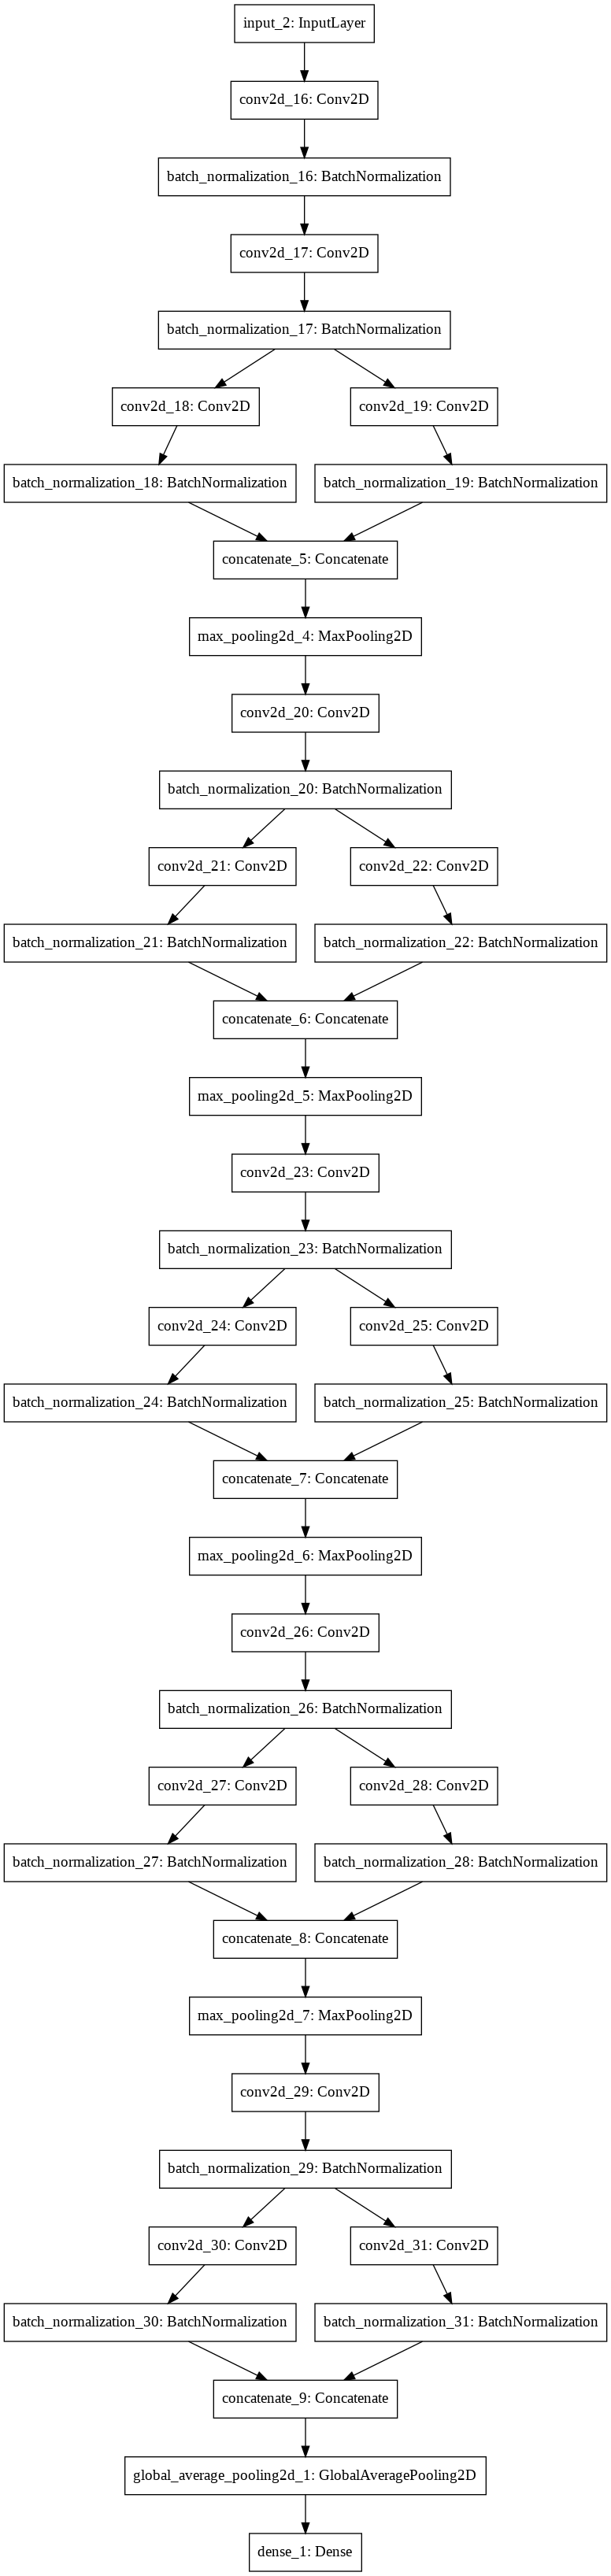

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

## Transfer Learning 1: VGGNet

In [31]:
from tensorflow.keras.applications import VGG16 #major popular architecture
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model. #original which had > 1000 categories#
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition #default#

base_model.trainable = False 

base_model.summary()

flat1 = Flatten()(base_model.layers[-1].output) #plugging in first half to the second half; from transfer learning model
class1 = Dense(1024, activation='relu')(flat1) #stack below
output = Dense(3, activation='softmax')(class1) #fully connected neural network to end off 
# define new model
model2 = Model(inputs=base_model.inputs, outputs=output)

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
______________________________________________________________

In [34]:
# Fit VGG16 model with frozen imagnet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping 
  
  mc = ModelCheckpoint('best_model_vggnet.h5', monitor='acc',mode='max', verbose=1, save_best_only=True) 
  red_lr= ReduceLROnPlateau(monitor='acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs
  es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=10)

  model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model2.fit(X_train, y_train,batch_size=1,
          epochs = 100, verbose=1, callbacks=[mc,red_lr, es])

Train on 3108 samples
Epoch 1/100
3104/3108 [============================>.] - ETA: 0s - loss: 0.1773 - acc: 0.9523
Epoch 00001: acc improved from -inf to 0.95238, saving model to best_model_vggnet.h5
3108/3108 [==============================] - 39s 13ms/sample - loss: 0.1771 - acc: 0.9524
Epoch 2/100
3105/3108 [============================>.] - ETA: 0s - loss: 0.0838 - acc: 0.9762
Epoch 00002: acc improved from 0.95238 to 0.97619, saving model to best_model_vggnet.h5
3108/3108 [==============================] - 39s 13ms/sample - loss: 0.0837 - acc: 0.9762
Epoch 3/100
3106/3108 [============================>.] - ETA: 0s - loss: 0.0627 - acc: 0.9794
Epoch 00003: acc improved from 0.97619 to 0.97909, saving model to best_model_vggnet.h5
3108/3108 [==============================] - 39s 13ms/sample - loss: 0.0632 - acc: 0.9791
Epoch 4/100
3105/3108 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9820
Epoch 00004: acc improved from 0.97909 to 0.98198, saving model to best

In [87]:
y_pred2 = model2.predict(X_test)

prediction_index2= np.argmax(y_pred2,axis=1)

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels2=list(map(lambda x: labels[x], prediction_index2))
print(predicted_labels2)

['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUM

In [36]:
y_val = y_test.idxmax(1)

In [37]:
model_eval_metrics(y_val,predicted_labels2,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.985861,0.986088,0.98647,0.98577,0,0,0,0


In [38]:
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0   

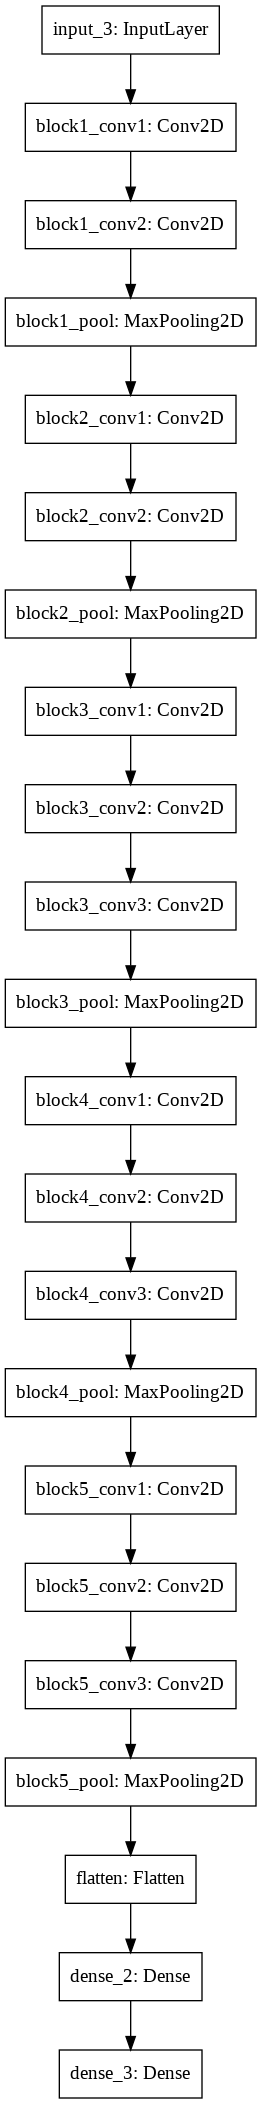

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='model2.png')

## Transfer Learning 2: InceptionV3 with 10 Unfrozen Layers

In [46]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VG16
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# Fine-tune everything up to this layer onwards
freeze_layers_after=10 #train first ten layers of convolution base#

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

In [47]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model3 = Model(inputs=base_model.inputs, outputs=output)

In [48]:
# Fit Inception model with some unfrozen imagnet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping #if accuracy doesn't change for two epochs, change the learning rate; for every two epochs that there is no change?
  
  mc = ModelCheckpoint('best_model_inception.h5', monitor='acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs
  es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=5)

  model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model3.fit(X_train, y_train,batch_size=1,
          epochs = 100, verbose=1, callbacks=[mc,red_lr, es])

Train on 3108 samples
Epoch 1/100
3106/3108 [============================>.] - ETA: 0s - loss: 1.2717 - acc: 0.3445
Epoch 00001: acc improved from -inf to 0.34459, saving model to best_model_inception.h5
3108/3108 [==============================] - 199s 64ms/sample - loss: 1.2719 - acc: 0.3446
Epoch 2/100
3106/3108 [============================>.] - ETA: 0s - loss: 1.2011 - acc: 0.3976
Epoch 00002: acc improved from 0.34459 to 0.39736, saving model to best_model_inception.h5
3108/3108 [==============================] - 75s 24ms/sample - loss: 1.2019 - acc: 0.3974
Epoch 3/100
3105/3108 [============================>.] - ETA: 0s - loss: 1.1361 - acc: 0.4538
Epoch 00003: acc improved from 0.39736 to 0.45367, saving model to best_model_inception.h5
3108/3108 [==============================] - 75s 24ms/sample - loss: 1.1360 - acc: 0.4537
Epoch 4/100
3107/3108 [============================>.] - ETA: 0s - loss: 1.0238 - acc: 0.5246
Epoch 00004: acc improved from 0.45367 to 0.52477, saving mod

In [89]:
y_pred3 = model3.predict(X_test)

prediction_index3= np.argmax(y_pred3,axis=1)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels3=list(map(lambda x: labels[x], prediction_index3))
print(predicted_labels3)

['COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'NORMAL', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'NORMAL', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'NORMAL', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'NORMAL', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'C

In [90]:
y_val = y_test.idxmax(1)

In [91]:
model_eval_metrics(y_val,predicted_labels3,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.268638,0.168145,0.232023,0.288182,0,0,0,0


In [ ]:
model3.summary()

#Not displaying because of length

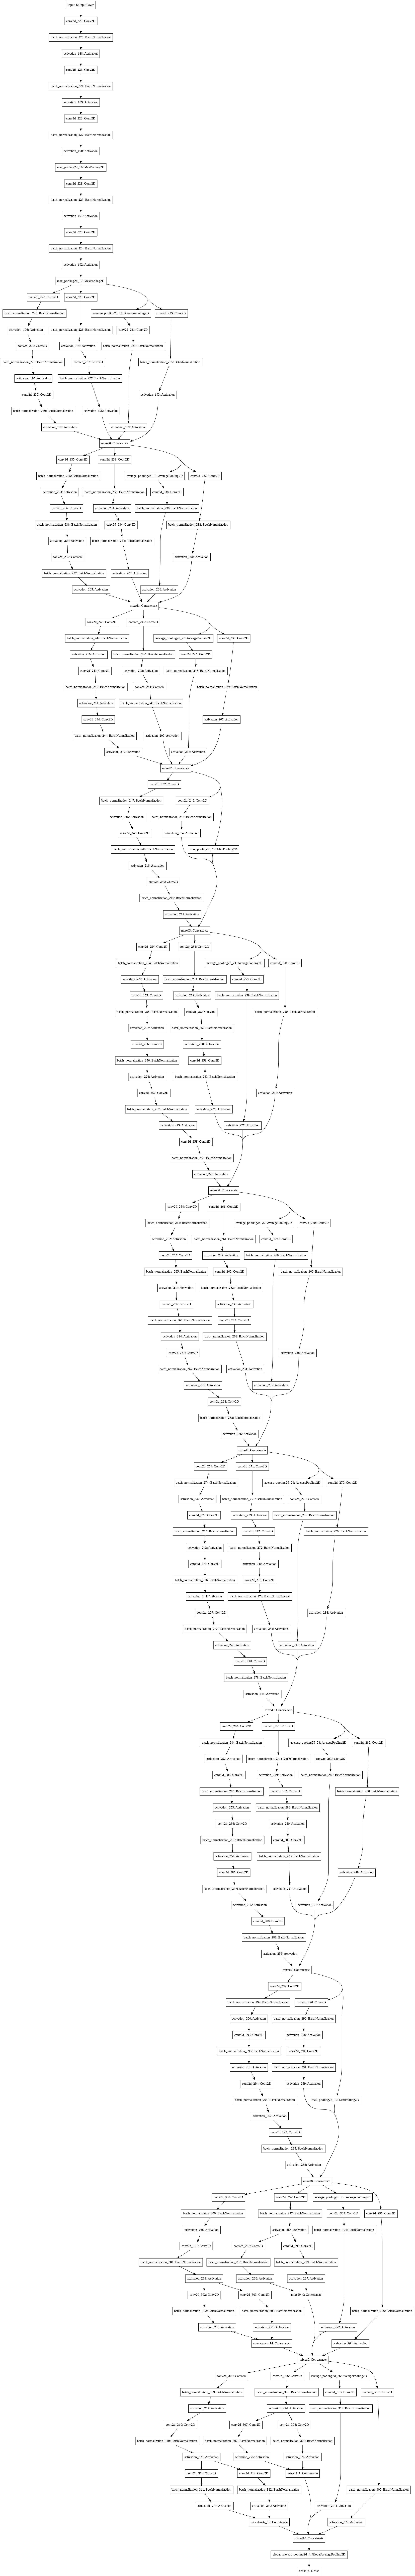

In [166]:
from tensorflow.keras.utils import plot_model
plot_model(model3, to_file='model3.png')

## Comparing between Models; Best Model

In [112]:
#Model 1
model_eval_metrics(y_val,predicted_labels1,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.952442,0.953481,0.956205,0.953403,0,0,0,0


In [70]:
#Model 2
model_eval_metrics(y_val,predicted_labels2,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.985861,0.986088,0.98647,0.98577,0,0,0,0


In [58]:
#Model 3
model_eval_metrics(y_val,predicted_labels3,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.268638,0.168145,0.232023,0.288182,0,0,0,0


The model that performed best was the first transfer learning model I tried, Model 2, the VGGNet model with all weights frozen and non-trainable. In other words, I simply imported the VGGNet Model from the ImageNet competition, and used its pre-trained weights, fit to my current image classification problem. This had an F1 Score of 0.986. 

The SqueezeNet Model with fire modules, the first model I tried, came in second with a F1 Score of 0.952. This was the only non transfer learning model I tried. 

The model with the most number of layers by far, the Inception Model, was the worst performer with a F1 Score of 0.269. This might be because this deep learning model had too many layers, given the dimensionality of this dataset. 

Looking at the three models I fitted to the COVID dataset, I suggest these takeaways with regard to the hyperparameters/features of successful models. First, transfer learning has clearly a lot of potential, given the success of the VGGNet, with minimal intervention from my end. However, one would want to exercise extreme caution about fitting huge transfer learning models to one's dataset, such as the Inception Model I tried, since these take very long to train (if some layers are unfrozen, like I did), and performance can also be dismal. Second, one might also wonder if VGGNet's model architecture has features that lend itself to successful image classification. 

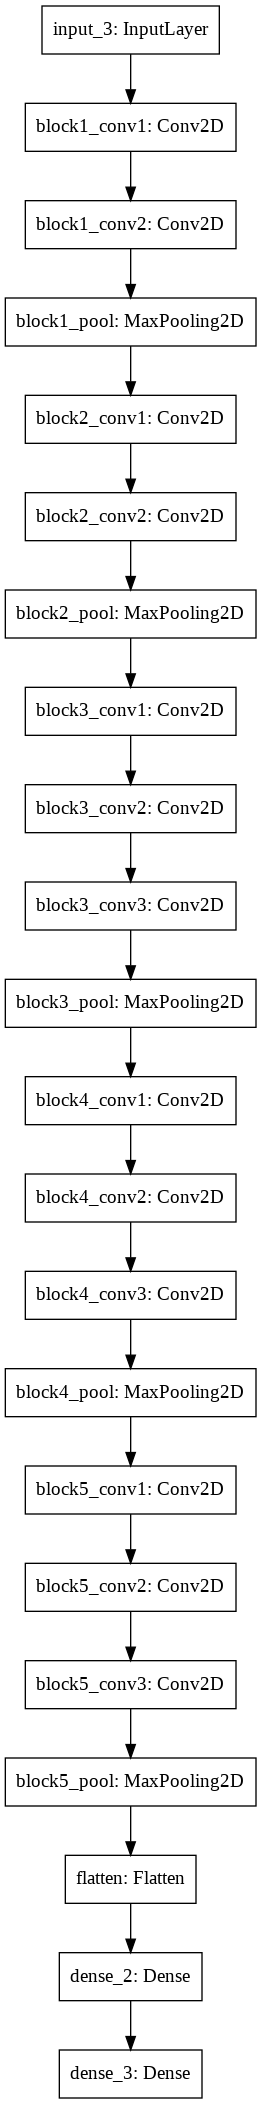

In [108]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='model2.png')

While certainly more model experimentation would be necessary for this claim, this is one case where having back to back convolutional layers (of two or three repetitions), followed by a maxpooling layer to reduce the size of each feature map over all channels, is very successful. A comparable feature was implemented in SqueezeNet, within the fire modules which implemented batch normalization after a convolutional layer, before splitting the output through two separate convolutional layers, which were then concatanated together and Max-Pooled. This placement of back to back convolutional layers in SqueezeNet also led to considerable success. It would be interesting to modify my existing SqueezeNet model, to have two back to back convolutional layers instead of a batch normalization process, as inspired by the VGGNet.

The unwieldly size of Inception Net for the current dataset aside, there also appear to be no back to back convolutional layers, since the output from a convolutional layer, no matter which branch in the inception modules, was always subject to an activation before the output from multiple branches of the Inception Net were concatanated. This might serve other problems or data sets better, but these features did not lead to Inception Net performing well in this particular use case.

# Upload Best Model to AIModelShare for COVID-19 X-Ray Image Class Hackathon

In [ ]:
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

In [72]:
import aimodelshare as ai

In [96]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model2, framework='keras', 
                                   transfer_learning=True, #important
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model2_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 83 -> 40


In [143]:
# Set credentials to submit new model/preprocessor

from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials-3.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [144]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [99]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

can't pickle module objects


In [100]:
def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model2.predict(X_test)))

prediction_index=predict_classes(model2.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 2 0 1 1 2 2 2 1 0 2 2 2 1 2 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 2 1 2 1 1 2 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 2 2 2 1 2 1 2 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 2 2 2 1 2 2 1 1 0 2 2 0 0 0 1 0 2 2 1 0 2 1 2
 2 0 1 0 0 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 2 2 1 0 2 2 0 0 2 0 2 0 2 1 2 0 1 1 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 1 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 1 2 1 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [101]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [102]:
# get metrics
model_eval_metrics(y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.985861,0.986088,0.98647,0.98577,0,0,0,0


In [103]:
# Submit_model() to leaderboard
#ai.submit_model("onnx_model2_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

True

In [167]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,timestamp,version
0,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:49:57.183806,7
2,0.958869,0.959279,0.960139,0.958700,keras,True,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers': [{'class_name...",mikedparrott,2021-03-03 19:07:56.066729,2
3,0.944730,0.944723,0.944812,0.945219,keras,False,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers': [{'class_name...",newusertest,2021-03-03 19:37:53.123942,3
4,0.303342,0.198319,0.200000,0.196667,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:41:25.314573,5


In [168]:
ai.stylize_leaderboard(data,category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,version
0,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,7
2,95.89%,95.93%,96.01%,95.87%,keras,True,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers...",mikedparrott,2
3,94.47%,94.47%,94.48%,94.52%,keras,False,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers...",newusertest,3
4,30.33%,19.83%,20.00%,19.67%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,5


# Best Model from LeaderBoard

## Learning from Model Structure and Optimization

At the point of my submission, my VGGNet model was the best in the LeaderBoard. However, the second ranking model, with a F1-Score of 0.959, was better than my SqueezeNet model, which performed as such: 

In [113]:
#Model 1 -- SqueezeNet with Fire Modules
model_eval_metrics(y_val,predicted_labels1,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.952442,0.953481,0.956205,0.953403,0,0,0,0


I already reflected on how I might improve my SqueezeNet model, relative to my best model, above.

In this last segment of the notebook, I utilize the AIModelShare platform's `instantiate_model()` function to read on my second best model, reflecting on how I can compare it against the second best model in the hackathon's leaderboard, and also practice using the `instantiate_model()` function of AIModelShare, which will be very useful in future exercises.

In [138]:
help(ai.aimsonnx) #Information on aimodelshare

Help on module aimodelshare.aimsonnx in aimodelshare:

NAME
    aimodelshare.aimsonnx - # data wrangling

FUNCTIONS
    instantiate_model(apiurl, aws_token, aws_client, version=None)
    
    model_to_onnx(model, framework, model_input=None, initial_types=None, transfer_learning=None, deep_learning=None, task_type=None)
        Transforms sklearn, keras, or pytorch model object into ONNX format 
        and extracts model metadata dictionary. The model metadata dictionary 
        is saved in the ONNX file's metadata_props. 
        
        Parameters: 
        model: fitted sklearn, keras, or pytorch model object
        Specifies the model object that will be converted to ONNX. 
        
        framework: {"sklearn", "keras", "pytorch"}
        Specifies the machine learning framework of the model object.
        
        model_input: array_like, default=None
        Required when framework="pytorch".
        
        initial_types: initial types tuple, default=None
        Require

In [150]:
from keras.initializers import glorot_uniform #https://stackoverflow.com/questions/53183865/unknown-initializer-glorotuniform-when-loading-keras-model

In [152]:
from keras.utils import CustomObjectScope
from aimodelshare.aimsonnx  import instantiate_model

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
  new_model = instantiate_model("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m", token, awscreds, version=2)

In [153]:
new_model

In [154]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 32)        1056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 32)        9

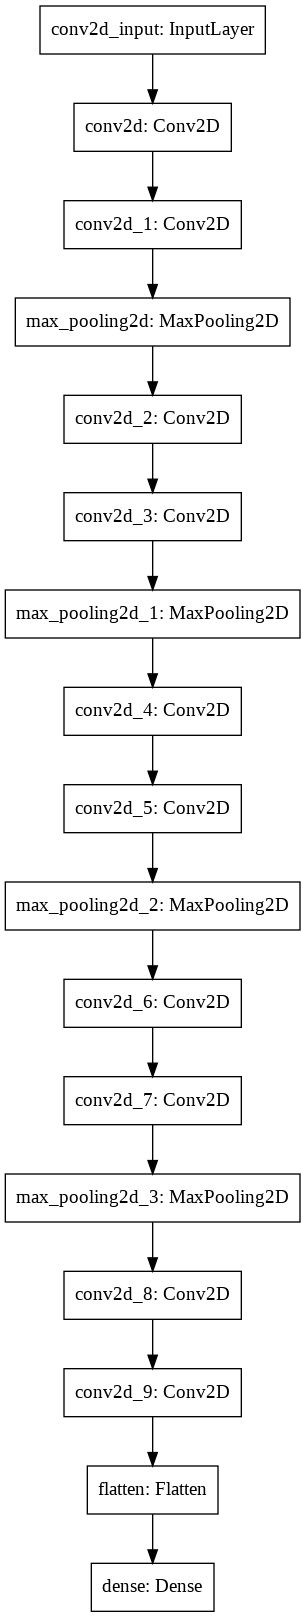

In [157]:
from tensorflow.keras.utils import plot_model
plot_model(new_model, to_file='new_model.png')

In terms of the sequence of the layers, this model is actually very similar to the best model I generated, the VGGNet transfer learning model. However, it has notably less channels than my VGGNet transfer learning model, which led to considerably less parameters. It also isn't a transfer learning model, so it could not benefit from the pre-trained weights in VGGNet. Finally, it also only had one fully connected layer at the very end of the model, while VGGNet had two. Hence, even this model might improve from these improvements. 

Relatively to my second-best performing SqueezeNet model, however, it performed better. Similar to my reflections on SqueezeNet versus my VGGNet transfer learning model above, perhaps my SqueezeNet model could have the batch normalization layers replaced with a second convolutional layer, right after the first. This is a feature of this instantiated model, which has back to back convolutional layers followed by a max pooling layer, repeated a few times. 

The instantiated model and my two better models all used the 'adam' optimizer, but another optimizer like stochastic gradient descent could also be attempted on my SqueezeNet module, to test whether its performance might be improved with a different optimizer.

## Fitting Instantiated Model and Evaluating on Test Data

In [161]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping #if accuracy doesn't change for two epochs, change the learning rate; for every two epochs that there is no change?
  
mc = ModelCheckpoint('best_model_instant.h5', monitor='acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
red_lr= ReduceLROnPlateau(monitor='acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs
es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=5)

new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

new_model.fit(X_train, y_train,batch_size=1,
        epochs = 100, verbose=1, callbacks=[mc,red_lr, es])

Epoch 1/100
3108/3108 [==============================] - 28s 9ms/step - loss: 0.1779 - acc: 0.9385

Epoch 00001: acc improved from -inf to 0.93855, saving model to best_model_instant.h5
Epoch 2/100
3108/3108 [==============================] - 26s 8ms/step - loss: 0.1443 - acc: 0.9485

Epoch 00002: acc improved from 0.93855 to 0.94852, saving model to best_model_instant.h5
Epoch 3/100
3108/3108 [==============================] - 26s 8ms/step - loss: 0.1289 - acc: 0.9553

Epoch 00003: acc improved from 0.94852 to 0.95528, saving model to best_model_instant.h5
Epoch 4/100
3108/3108 [==============================] - 26s 8ms/step - loss: 0.1182 - acc: 0.9598

Epoch 00004: acc improved from 0.95528 to 0.95978, saving model to best_model_instant.h5
Epoch 5/100
3108/3108 [==============================] - 26s 8ms/step - loss: 0.1137 - acc: 0.9591

Epoch 00005: acc did not improve from 0.95978
Epoch 6/100
3108/3108 [==============================] - 26s 8ms/step - loss: 0.1086 - acc: 0.9665

E

In [162]:
y_pred4 = new_model.predict(X_test)

prediction_index4= np.argmax(y_pred4,axis=1)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels4=list(map(lambda x: labels[x], prediction_index4))
print(predicted_labels4)

['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMON

In [163]:
y_val = y_test.idxmax(1)

model_eval_metrics(y_val,predicted_labels4,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.958869,0.959455,0.960307,0.95885,0,0,0,0


As expected, this is extremely similar to the results for the instantiated model, as submitted to AIModelShare, since this model was trained and tested on the exact same `train_test_split`, with the same random seed number. 